<a href="https://colab.research.google.com/github/BU0x01/Chest-X-Ray-Classifier/blob/main/Chest_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
from tensorflow.keras.utils import plot_model


LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

!apt-get install graphviz -y
!pip install pydot

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Great! You clicked on it correctly. Now let's get started.


In [ ]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [ ]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [ ]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [ ]:
from PIL import Image, ImageDraw, ImageFont

# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

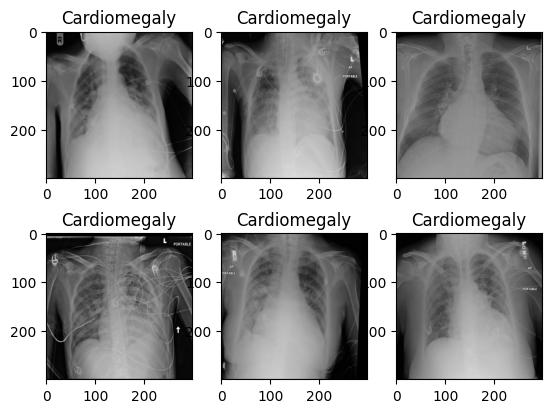

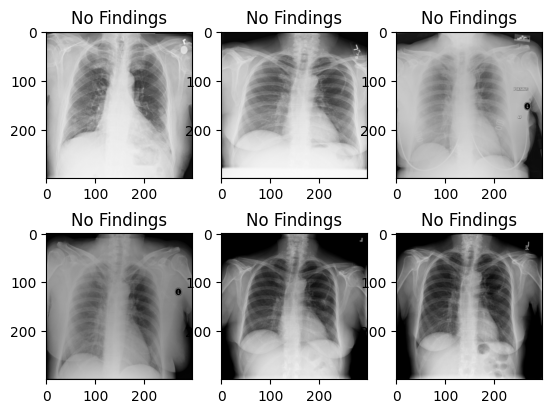

In [ ]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

In [ ]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 232 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


In [ ]:
# Define the base model using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Load weights pre-trained on ImageNet
)

# Freeze the base model to keep the pre-trained weights unchanged
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Define data augmentation layers to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.05, 0.05),           # Translation
    tf.keras.layers.RandomContrast(0.1),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.1),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.1, 0.1)])                   # Random zoom

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs) # Apply data augmentation
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define early stopping callback to stop training when validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

In [ ]:
# Set the number of epochs for initial training
initial_epochs = 40

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 122s 30s/step - accuracy: 0.4879 - loss: 0.8173 - val_accuracy: 0.5167 - val_loss: 0.6842
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 116s 22s/step - accuracy: 0.5407 - loss: 0.7197 - val_accuracy: 0.5833 - val_loss: 0.6662
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 139s 21s/step - accuracy: 0.5632 - loss: 0.7494 - val_accuracy: 0.6167 - val_loss: 0.6651
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 22s/step - accuracy: 0.5438 - loss: 0.6869 - val_accuracy: 0.6333 - val_loss: 0.6475
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 22s/step - accuracy: 0.5895 - loss: 0.7200 - val_accuracy: 0.6333 - val_loss: 0.6308
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 143s 22s/step - accuracy: 0.6033 - loss: 0.7219 - val_accuracy: 0.6333 - val_loss: 0.6196
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 141s 22s/step - accuracy: 0.6048 - loss: 0.6784 - val_accuracy: 0.6333 - val_loss: 0.6296
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 23s/step - accuracy: 0.6692 - loss: 0.6279 - val_accuracy: 0.6333 - val_loss: 

In [ ]:
base_model.trainable = True
fine_tune_at = 249 # specific to this architecture

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set the number of epochs for fine-tuning
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=validation_dataset,
    callbacks=[early_stopping]  # Use early stopping
)

Epoch 40/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 131s 29s/step - accuracy: 0.5499 - loss: 0.7224 - val_accuracy: 0.7833 - val_loss: 0.5019
Epoch 41/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 137s 27s/step - accuracy: 0.5535 - loss: 0.7349 - val_accuracy: 0.7500 - val_loss: 0.5003
Epoch 42/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 106s 26s/step - accuracy: 0.5426 - loss: 0.7115 - val_accuracy: 0.7500 - val_loss: 0.4989
Epoch 43/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 105s 27s/step - accuracy: 0.6072 - loss: 0.6496 - val_accuracy: 0.7500 - val_loss: 0.4982
Epoch 44/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 26s/step - accuracy: 0.5954 - loss: 0.6577 - val_accuracy: 0.7500 - val_loss: 0.4993
Epoch 45/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 140s 26s/step - accuracy: 0.5886 - loss: 0.6580 - val_accuracy: 0.7333 - val_loss: 0.4987
Epoch 46/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 145s 27s/step - accuracy: 0.6285 - loss: 0.5907 - val_accuracy: 0.7333 - val_loss: 0.4995
Epoch 47/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 103s 27s/step - accuracy: 0.6792 - loss: 0.5649 - val_accuracy: 0.7167 - v

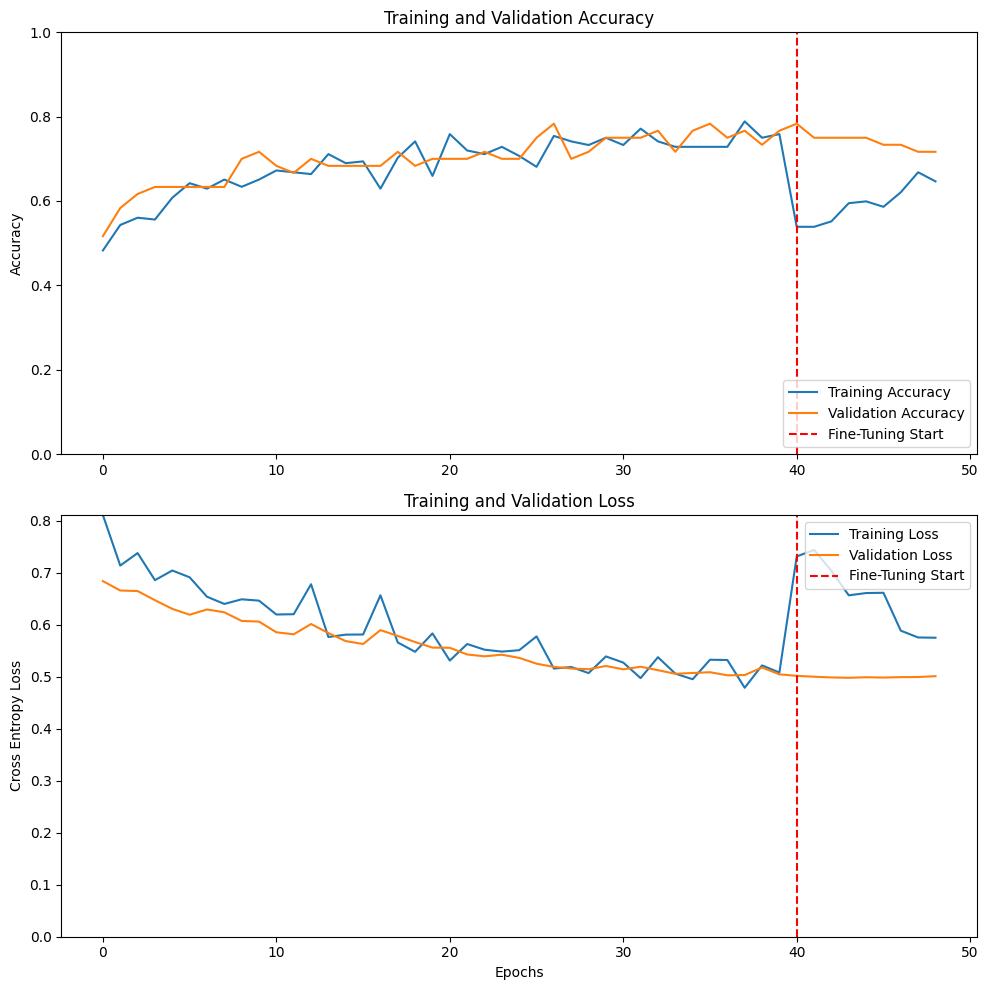

In [ ]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Total epochs
total_epochs = len(acc)
fine_tune_start = initial_epochs  # Epoch where fine-tuning starts

plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()


In [ ]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  expanded = np.expand_dims(image_np, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  expanded = np.expand_dims(img, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [ ]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.935593
1,/content/medical-ai/images/Cardiomegaly/test/p...,00004342_002.jpg,pos,pos,0.916090
2,/content/medical-ai/images/Cardiomegaly/test/p...,00010381_000.jpg,pos,pos,0.877506
3,/content/medical-ai/images/Cardiomegaly/test/p...,00019187_000.jpg,pos,pos,0.876219
4,/content/medical-ai/images/Cardiomegaly/test/p...,00030206_013.jpg,pos,pos,0.873041


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


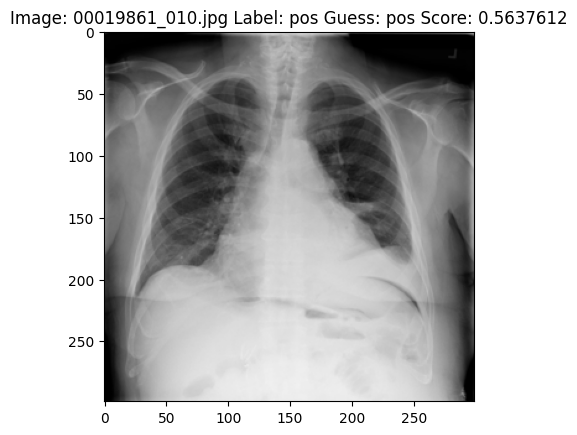

In [ ]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [ ]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.935593
5,00004822_051.jpg,pos,pos,0.872094
10,00004342_023.jpg,pos,pos,0.784264
15,00018187_029.jpg,pos,pos,0.696944
20,00000083_000.jpg,neg,pos,0.637660
25,00000756_001.jpg,pos,pos,0.612967
30,00000091_007.jpg,neg,pos,0.543338
35,00000092_000.jpg,neg,pos,0.528013
40,00004344_014.jpg,pos,neg,0.461422
45,00000078_000.jpg,neg,neg,0.351152


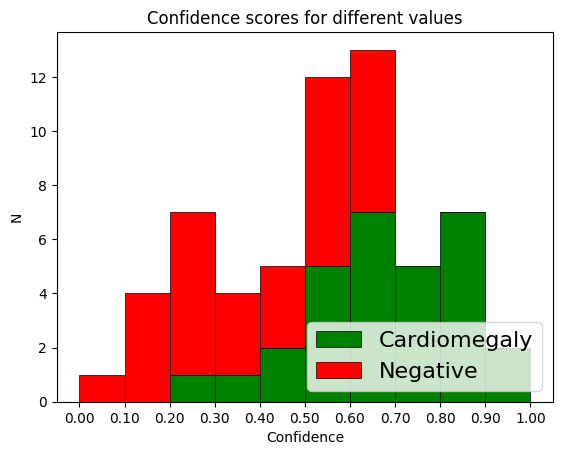

In [ ]:
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

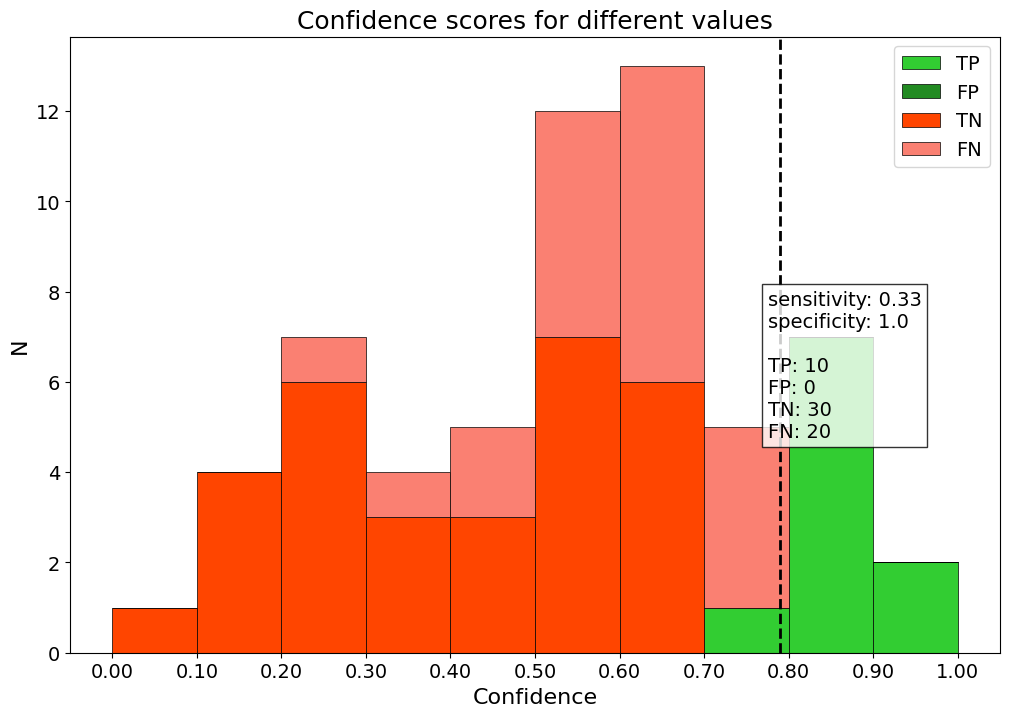

In [ ]:
def create_with_cutoff(cutoff):
    __, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
    TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

    # Plot the histogram
    plt.hist([TP, FP, TN, FN], bins=np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
             label=['TP', 'FP', 'TN', 'FN'])

    plt.xlabel('Confidence', fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title('Confidence scores for different values', fontsize=18)
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
    plt.legend(loc="upper right", fontsize=14)  # Adjusted legend location to avoid overlap

    # Calculate statistics
    sens = round(len(TP) / (len(TP) + len(FN)), 2)
    spec = round(len(TN) / (len(TN) + len(FP)), 2)
    stats = f"sensitivity: {sens}\nspecificity: {spec}\n\nTP: {len(TP)}\nFP: {len(FP)}\nTN: {len(TN)}\nFN: {len(FN)}"

    # Display stats in a box to make it more readable
    plt.text(0.75, 0.35, stats, fontsize=14, transform=ax.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

create_with_cutoff(cutoff)

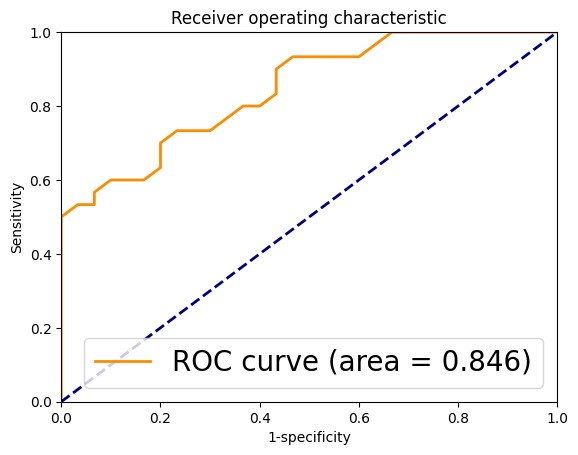

In [ ]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

In [ ]:
model.export('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

Saved artifact at '/content/export/Cardiomegaly'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134627899376848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627899377232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627899377808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627899378192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627899378576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627970721232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627973237072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627973236112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627973236688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134627973235536: TensorSpec(shape=(), dtype=tf.resource, name=None)
